## Data Wrangling and Exploration
ref:https://github.com/cs109/content/blob/master/lec_04_wrangling.ipynb

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#tell pandas to display wide tables as pretty HTML tables
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [24]:
!head imdb_top_10000.txt

tt0111161	The Shawshank Redemption (1994)	1994	 9.2	619479	142 mins.	Crime|Drama
tt0110912	Pulp Fiction (1994)	1994	 9.0	490065	154 mins.	Crime|Thriller
tt0137523	Fight Club (1999)	1999	 8.8	458173	139 mins.	Drama|Mystery|Thriller
tt0133093	The Matrix (1999)	1999	 8.7	448114	136 mins.	Action|Adventure|Sci-Fi
tt1375666	Inception (2010)	2010	 8.9	385149	148 mins.	Action|Adventure|Sci-Fi|Thriller
tt0109830	Forrest Gump (1994)	1994	 8.7	368994	142 mins.	Comedy|Drama|Romance
tt0169547	American Beauty (1999)	1999	 8.6	338332	122 mins.	Drama
tt0499549	Avatar (2009)	2009	 8.1	336855	162 mins.	Action|Adventure|Fantasy|Sci-Fi
tt0108052	Schindler's List (1993)	1993	 8.9	325888	195 mins.	Biography|Drama|History|War
tt0080684	Star Wars: Episode V - The Empire Strikes Back (1980)	1980	 8.8	320105	124 mins.	Action|Adventure|Family|Sci-Fi


## 1. Build a DataFrame
The textfile is tab-separated, and doesn't have any column headers. We set the appropriate keywords in pd.read_csv to handle this.

In [25]:
names =['imdbID','title','year','score','votes','runtime','genres']
data = pd.read_csv('imdb_top_10000.txt',delimiter='\t',names=names).dropna()
print "Number of rows: %i" %data.shape[0]
data.head()

Number of rows: 9999


,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142 mins.,Crime|Drama
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154 mins.,Crime|Thriller
2,tt0137523,Fight Club (1999),1999,8.8,458173,139 mins.,Drama|Mystery|Thriller
3,tt0133093,The Matrix (1999),1999,8.7,448114,136 mins.,Action|Adventure|Sci-Fi
4,tt1375666,Inception (2010),2010,8.9,385149,148 mins.,Action|Adventure|Sci-Fi|Thriller


## 2. Clean the DataFrame
There are several problems with the DataFrame at this point:
1. The runtime column describes a number, but is stored as a string
1. The genres column is not atomic -- it aggregates several genres together. This makes it hard, for example, to  extract which movies are Comedies.
1. The movie year is repeated in the title and year column

### Fixing the runtime column
The following script converts a string like '142 mins' to the number '142'

In [26]:
dirty='142 mins.'
number,text = dirty.split(' ')
clean = int(number)
print number

142


We can package this up into a list comprehension

In [27]:
clean_runtime =[float(r.split(' ')[0]) for r in data['runtime']]
data['runtime']=clean_runtime
data.head()

,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142.0,Crime|Drama
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154.0,Crime|Thriller
2,tt0137523,Fight Club (1999),1999,8.8,458173,139.0,Drama|Mystery|Thriller
3,tt0133093,The Matrix (1999),1999,8.7,448114,136.0,Action|Adventure|Sci-Fi
4,tt1375666,Inception (2010),2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller


### Splitting up the genres
We can use the concept of indicator variables to split the genres column into many columns. Each new column will correspond to a single genre, and each cell will be True or False.

In [28]:
#determine the unique genres
genres=set()
for m in data['genres']:
    genres.update(g for g in m.split('|'))
genres=sorted(genres)

#make a column for each genre
for genre in genres:
    data[genre]=[genre in movie.split('|') for movie in data['genres']]
    
data.head()

,imdbID,title,year,score,votes,runtime,genres,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142.0,Crime|Drama,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154.0,Crime|Thriller,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,tt0137523,Fight Club (1999),1999,8.8,458173,139.0,Drama|Mystery|Thriller,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
3,tt0133093,The Matrix (1999),1999,8.7,448114,136.0,Action|Adventure|Sci-Fi,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,tt1375666,Inception (2010),2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False


### Removing year from the title
We can fix each element by stripping off the last 7 characters

In [29]:
data['title']=[t[0:-7] for t in data['title']]
data.head()

,imdbID,title,year,score,votes,runtime,genres,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0111161,The Shawshank Redemption,1994,9.2,619479,142.0,Crime|Drama,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0110912,Pulp Fiction,1994,9.0,490065,154.0,Crime|Thriller,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,tt0137523,Fight Club,1999,8.8,458173,139.0,Drama|Mystery|Thriller,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
3,tt0133093,The Matrix,1999,8.7,448114,136.0,Action|Adventure|Sci-Fi,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,tt1375666,Inception,2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False


## 3. Explore global properties

In [30]:
data[['score','runtime','year','votes']].describe()

,score,runtime,year,votes
count,9999.000000,9999.000000,9999.000000,9999.000000
mean,6.385989,103.580358,1993.471447,16605.462946
std,1.189965,26.629310,14.830049,34564.883945
min,1.500000,0.000000,1950.000000,1356.000000
25%,5.700000,93.000000,1986.000000,2334.500000
50%,6.600000,102.000000,1998.000000,4981.000000
75%,7.200000,115.000000,2005.000000,15278.500000
max,9.200000,450.000000,2011.000000,619479.000000


In [31]:
# a runtime of 0 looks suspicious. How many movies have that?
print len(data[data['runtime']==0])
# best to flag those bad data as NAN
data[data['runtime']==0]=np.nan

282


In [32]:
data['runtime'].describe()

count    9717.000000
mean      106.586395
std        20.230330
min        45.000000
25%        93.000000
50%       103.000000
75%       115.000000
max       450.000000
Name: runtime, dtype: float64

### Make some basic plots

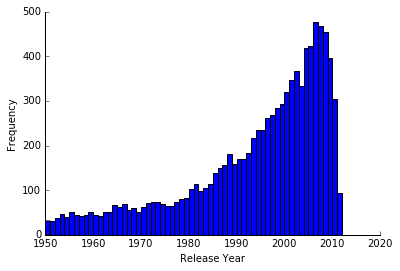

In [49]:
ax=data['year'].plot.hist(bins=np.arange(1950, 2013))
ax.set_xlabel('Release Year')
remove_border()

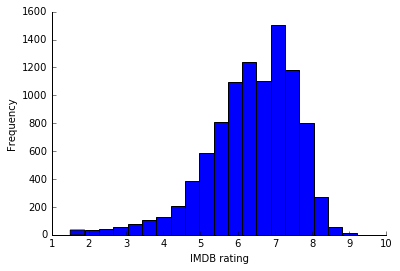

In [50]:
ax=data['score'].plot.hist(bins=20)
ax.set_xlabel('IMDB rating')
remove_border()

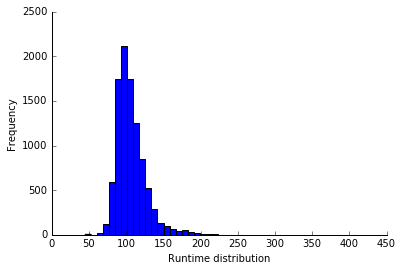

In [52]:
ax=data['runtime'].plot.hist(bins=50)
ax.set_xlabel('Runtime distribution')
remove_border()

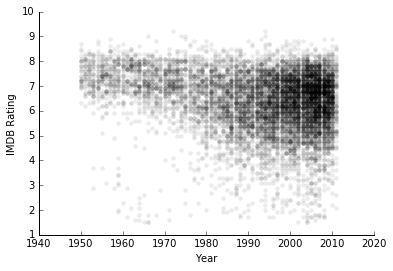

In [54]:
plt.scatter(data['year'],data['score'],lw=0,alpha=.08,color='k')
plt.xlabel("Year")
plt.ylabel('IMDB Rating')
remove_border()

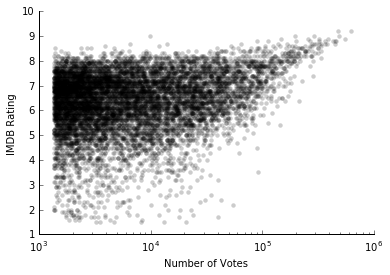

In [55]:
plt.scatter(data.votes, data.score, lw=0, alpha=.2, color='k')
plt.xlabel("Number of Votes")
plt.ylabel("IMDB Rating")
plt.xscale('log')
remove_border()

### Identify outliers

In [56]:
# low-score movies with lots of votes
data[(data['votes']>9e4)&(data['score']<5)][['title','year','score','votes','genres']]

,title,year,score,votes,genres
317,New Moon,2009.0,4.5,90457.0,Adventure|Drama|Fantasy|Romance
334,Batman & Robin,1997.0,3.5,91875.0,Action|Crime|Fantasy|Sci-Fi


In [57]:
# the lowest rated movies
data[data['score']==data['score'].min()][['title','year','score','votes','genres']]

,title,year,score,votes,genres
1982,Manos: The Hands of Fate,1966.0,1.5,20927.0,Horror
2793,Superbabies: Baby Geniuses 2,2004.0,1.5,13196.0,Comedy|Family
3746,Daniel the Wizard,2004.0,1.5,8271.0,Comedy|Crime|Family|Fantasy|Horror
5158,Ben & Arthur,2002.0,1.5,4675.0,Drama|Romance
5993,Night Train to Mundo Fine,1966.0,1.5,3542.0,Action|Adventure|Crime|War
6257,Monster a-Go Go,1965.0,1.5,3255.0,Sci-Fi|Horror


In [58]:
# the highest rated movies
data[data['score']==data['score'].max()][['title','year','score','votes','genres']]

,title,year,score,votes,genres
0,The Shawshank Redemption,1994.0,9.2,619479.0,Crime|Drama
26,The Godfather,1972.0,9.2,474189.0,Crime|Drama


### Run aggregation functions like sum over several rows or columns
what genres are the most frequent?

In [59]:
# sum sums over rows by default
genre_count=np.sort(data[genres].sum())[::-1] # [::-1] makes a copy of the same list in reverse order
pd.DataFrame({'Genre Count': genre_count})

,Genre Count
0,5527.0
1,3807.0
2,2758.0
3,2369.0
4,1832.0
5,1813.0
6,1281.0
7,1173.0
8,987.0
9,902.0


In [62]:
#axis=1 sums over columns instead
genre_count =data[genres].sum(axis=1)
print "Average move has %0.2f genres"%genre_count.mean()
genre_count.describe()

Average move has 2.68 genres


count    9999.000000
mean        2.678668
std         1.238209
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
dtype: float64

### Explore Group Properties
Let's split up movies by decade

In [68]:
decade=(data['year']//10)*10
tyd=data[['title','year']]
tyd['decade']=decade
tyd.head()

/Users/yuchengtsai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,title,year,decade
0,The Shawshank Redemption,1994.0,1990.0
1,Pulp Fiction,1994.0,1990.0
2,Fight Club,1999.0,1990.0
3,The Matrix,1999.0,1990.0
4,Inception,2010.0,2010.0


GroupBy will gather movies into groups with equal decade values

year
1950.0    7.248456
1960.0    7.063521
1970.0    6.815642
1980.0    6.248289
1990.0    6.197537
2000.0    6.280190
2010.0    6.344081
Name: Decade Mean, dtype: float64


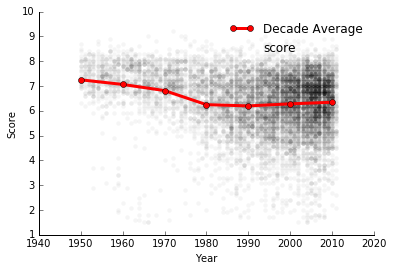

In [70]:
#mean score for all movies in each decade
decade_mean=data.groupby(decade).score.mean()
decade_mean.name='Decade Mean'
print decade_mean

plt.plot(decade_mean.index,decade_mean.values,'o-',color='r',lw=3,label='Decade Average')
plt.scatter(data.year,data.score,alpha=.04,lw=0,color='k')
plt.xlabel("Year")
plt.ylabel("Score")
plt.legend(frameon=False)
remove_border()